In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

from load_puma_data import load_barenco_puma
import math
import random

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline

In [7]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p)    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m = Y[:-1]
σ2 = Y_var[:-1]

## Metropolis Hastings Custom MCMC Algorithm

In [110]:
# Parameters
w_j0 = 1    # Interaction bias (TODO)
f_i = np.ones(N_p)
v_i = 1 # Fix this to 1 if translation model is not used (pg.8)
l2_i = 0.3
δbar_i = 1
h_δ = 1
a_δ = -0.5
b2_δ = 2
b = np.ones(num_genes)
s = np.ones(num_genes)
d = np.ones(num_genes)
a = np.ones(num_genes) # TODO initial conditions
w = np.ones((num_genes, I))
σm2 = np.ones(num_genes)


In [111]:
# Priors
def fbar_prior(fbar):
    t_1 = np.reshape(np.tile(τ, N_p), [N_p, N_p]).T
    t_2 = np.reshape(np.tile(τ, N_p), [N_p, N_p])
    t_dist = t_1-t_2
    
    K = v_i * np.exp(-np.square(t_dist)/(2*l2_i))
    m = np.zeros(N_p, dtype='float64')
    return np.float64(tfd.MultivariateNormalFullCovariance(m, K).prob(fbar))

def δbar_prior(δ):
    return np.float64(tfd.Normal(a_δ, b2_δ).prob(δ))

# Likelihood
def G(n, k, p_i):
    # TODO add binary vector x_j for prior network knowledge (pg.3)
    numerator = np.exp(-d*(t[n]-τ[k]))
    denominator = (1+np.exp(-w_j0-sum([w[:,i]*np.log(p_i[k]) for i in range(I)])))
    return numerator/denominator

    
def likelihood(δbar):
    # Take relevant parameters out of log-space
    δ = np.exp(δbar)
#     print('exped', δ)
    # Define p_i vector
    p_i = np.zeros(N_p)
    for n in range(N_p):
        N_pn = n#n*10+n
        p_i[n] = np.trapz([f_i[k] * np.exp(-δ*(τ[n]-τ[k])) for k in range(N_pn)])
#     print('pi', p_i)
    
    # Calculate m_pred
    m_pred = np.zeros((num_genes, N_m))
    for n in range(N_m):
        N_pn = n*10+n
        ys =  np.array([G(n, k, p_i) for k in range(N_pn)])
        if ys.shape[0] == 0:
            ys = np.zeros((0, num_genes))
        integrals = np.array([np.trapz(ys[:, i]) for i in range(num_genes)])
#         print('integrals', integrals)
        m_pred[:, n] = b/d + (a-b/d) * np.exp(-d*t[n]) + s*integrals

#     print(m_pred, m)
    lik = 1
    for j in range(num_genes):
        prob = tfd.Normal(m[j], σ2[j]+σm2[j]).prob(m_pred[j])
        lik *= tf.reduce_prod(prob)
    return lik


[[1.00000000e+000 9.46393893e-001 8.02209346e-001 ... 9.78639423e-099
  8.01496436e-102 5.87928270e-105]
 [9.46393893e-001 1.00000000e+000 9.46393893e-001 ... 1.07025601e-095
  9.78639423e-099 8.01496436e-102]
 [8.02209346e-001 9.46393893e-001 1.00000000e+000 ... 1.04832636e-092
  1.07025601e-095 9.78639423e-099]
 ...
 [9.78639423e-099 1.07025601e-095 1.04832636e-092 ... 1.00000000e+000
  9.46393893e-001 8.02209346e-001]
 [8.01496436e-102 9.78639423e-099 1.07025601e-095 ... 9.46393893e-001
  1.00000000e+000 9.46393893e-001]
 [5.87928270e-105 8.01496436e-102 9.78639423e-099 ... 8.02209346e-001
  9.46393893e-001 1.00000000e+000]]


In [97]:
print('----- Metropolis Begins -----')

params = { 'δ': list() }
T = 100



# print(likelihood(δbar_i))
for _ in range(T):
    # Untransformed tf mRNA vectors F
    # Proposal distribution
    for i in range(I):
        # Gibbs step
        z_i = tfd.Normal().sample()
        Q = fbar_prior()
        fstar  = Q.sample()
        acceptance = min(1, g(fstar)/g(f_i))
    
    
    # Log of translation ODE degradation rates
    for i in range(I):
        # Proposal distribution
        Q = tfd.Normal(δbar_i, h_δ)
        δstar = Q.sample() # δstar is in log-space, i.e. δstar = δbar*
        g = lambda δbar: likelihood(δbar) * δbar_prior(δbar)
        acceptance = min(1, g(δstar)/g(δbar_i))
        if random.random() < acceptance:
            δbar_i = δstar
            params['δ'].append(δstar)

----- Metropolis Begins -----
δstar tf.Tensor(2.7451339, shape=(), dtype=float32) 0.05348000302910805 tf.Tensor(1.8948398390835963e-22, shape=(), dtype=float64)
acceptance 1
δstar tf.Tensor(3.9113176, shape=(), dtype=float32) 0.017517561092972755 tf.Tensor(3.0022051101479928e-24, shape=(), dtype=float64)
acceptance tf.Tensor(0.005189793409865162, shape=(), dtype=float64)


c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


δstar tf.Tensor(2.8651726, shape=(), dtype=float32) 0.04843008145689964 tf.Tensor(7.311042935898202e-23, shape=(), dtype=float64)
acceptance tf.Tensor(0.34940619719686544, shape=(), dtype=float64)
δstar tf.Tensor(3.6660004, shape=(), dtype=float32) 0.02278779074549675 tf.Tensor(3.2064843366453284e-24, shape=(), dtype=float64)
acceptance tf.Tensor(0.02063653658010242, shape=(), dtype=float64)
δstar tf.Tensor(4.346013, shape=(), dtype=float32) 0.010592957027256489 tf.Tensor(2.970703666572638e-24, shape=(), dtype=float64)
acceptance tf.Tensor(0.008887549013261243, shape=(), dtype=float64)
δstar tf.Tensor(2.7831204, shape=(), dtype=float32) 0.051847659051418304 tf.Tensor(1.4117410203002487e-22, shape=(), dtype=float64)
acceptance 1
δstar tf.Tensor(2.9357913, shape=(), dtype=float32) 0.045608170330524445 tf.Tensor(4.199133550224343e-23, shape=(), dtype=float64)
acceptance tf.Tensor(0.2616484405588434, shape=(), dtype=float64)
δstar tf.Tensor(3.7580714, shape=(), dtype=float32) 0.02068218961

δstar tf.Tensor(2.8149009, shape=(), dtype=float32) 0.05050632357597351 tf.Tensor(1.0956603206430695e-22, shape=(), dtype=float64)
acceptance tf.Tensor(0.19366219992482914, shape=(), dtype=float64)
δstar tf.Tensor(3.4961, shape=(), dtype=float32) 0.02710091881453991 tf.Tensor(3.741048867115947e-24, shape=(), dtype=float64)
acceptance tf.Tensor(0.003548138521388431, shape=(), dtype=float64)
δstar tf.Tensor(0.5989505, shape=(), dtype=float32) 0.1715214103460312 tf.Tensor(7.694778049684117e-70, shape=(), dtype=float64)
acceptance tf.Tensor(4.618889863521978e-48, shape=(), dtype=float64)
δstar tf.Tensor(2.8277037, shape=(), dtype=float32) 0.049972254782915115 tf.Tensor(9.884232197337037e-23, shape=(), dtype=float64)
acceptance tf.Tensor(0.17286021743306615, shape=(), dtype=float64)
δstar tf.Tensor(1.3402532, shape=(), dtype=float32) 0.13062791526317596 tf.Tensor(4.708234902758181e-48, shape=(), dtype=float64)
acceptance tf.Tensor(2.1523717762071646e-26, shape=(), dtype=float64)
δstar tf.Te

acceptance tf.Tensor(0.0014552909647204755, shape=(), dtype=float64)
δstar tf.Tensor(2.7476704, shape=(), dtype=float32) 0.05337001383304596 tf.Tensor(1.858759431550799e-22, shape=(), dtype=float64)
acceptance tf.Tensor(0.46277717919358174, shape=(), dtype=float64)
δstar tf.Tensor(3.520589, shape=(), dtype=float32) 0.026443956419825554 tf.Tensor(3.624679846034011e-24, shape=(), dtype=float64)
acceptance tf.Tensor(0.004471441155818189, shape=(), dtype=float64)
δstar tf.Tensor(1.449469, shape=(), dtype=float32) 0.12404146790504456 tf.Tensor(4.1442881433556034e-44, shape=(), dtype=float64)
acceptance tf.Tensor(2.398105440593746e-22, shape=(), dtype=float64)
δstar tf.Tensor(2.7949214, shape=(), dtype=float32) 0.05134698376059532 tf.Tensor(1.2855985188902703e-22, shape=(), dtype=float64)
acceptance tf.Tensor(0.30794399145909734, shape=(), dtype=float64)
δstar tf.Tensor(4.0417705, shape=(), dtype=float32) 0.015138023532927036 tf.Tensor(2.9793943976201373e-24, shape=(), dtype=float64)
accepta

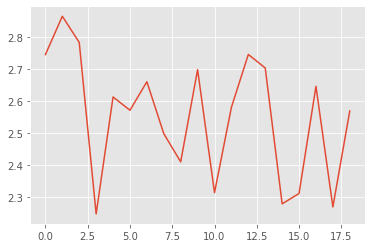

In [112]:
plt.plot(params['δ'])